In [86]:
!pip3 install numpy
!pip3 install pandas
!pip3 install matplotlib
!pip3 install scipy

In [87]:
import tarfile
import numpy as np
from scipy.sparse import coo_matrix
import os
import tempfile
import matplotlib.pyplot as plt

In [118]:
def load_hic_matrix(tar_path, matrix_name, target_bin_size=1000000):
    """Load Hi-C matrix and rebin to target_bin_size (default 1MB)."""
    # Extract and read matrix
    temp_dir = tempfile.mkdtemp()
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall(temp_dir)
    
    matrix_path = os.path.join(temp_dir, f'{matrix_name}.matrix')
    # Read file line by line, filtering out rows with missing values
    rows = []
    with open(matrix_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 3:
                try:
                    rows.append([float(parts[0]), float(parts[1]), float(parts[2])])
                except ValueError:
                    continue
    
    data = np.array(rows, dtype=np.float32)
    bin1_pos = data[:, 0].astype(int)
    bin2_pos = data[:, 1].astype(int)
    values = data[:, 2]
    
    # Bin positions to target_bin_size (1MB)
    bin1_idx = (bin1_pos // target_bin_size).astype(int)
    bin2_idx = (bin2_pos // target_bin_size).astype(int)
    
    # Create adjacency matrix
    n_bins = max(bin1_idx.max(), bin2_idx.max()) + 1
    adj_matrix = coo_matrix((values, (bin1_idx, bin2_idx)), shape=(n_bins, n_bins))
    
    # Make symmetric
    adj_matrix = adj_matrix + adj_matrix.T
    adj_matrix.setdiag(adj_matrix.diagonal() / 2)
    
    # Clean up
    os.remove(matrix_path)
    os.rmdir(temp_dir)
    
    return adj_matrix.toarray()

# Load all data
stages = ['early-g1', 'mid-g1', 'late-g1']
chromosomes = ['chr9', 'chr10', 'chr11', 'chr12']
BIN_SIZE = 1000000  # 1MB

hic_data = {}
for stage in stages:
    hic_data[stage] = {}
    for chrom in chromosomes:
        tar_path = f'{stage}/{chrom}.tar.gz'
        adj_matrix = load_hic_matrix(tar_path, chrom, BIN_SIZE)
        hic_data[stage][chrom] = adj_matrix
        print(f'{stage}/{chrom}: shape {adj_matrix.shape}')



early-g1/chr9: shape (125, 125)
early-g1/chr10: shape (130, 130)
early-g1/chr11: shape (122, 122)
early-g1/chr12: shape (122, 122)
mid-g1/chr9: shape (125, 125)
mid-g1/chr10: shape (130, 130)
mid-g1/chr11: shape (122, 122)
mid-g1/chr12: shape (122, 122)
late-g1/chr9: shape (125, 125)
late-g1/chr10: shape (130, 130)
late-g1/chr11: shape (122, 122)
late-g1/chr12: shape (122, 122)


Example matrix shape: (125, 125)


/var/folders/l1/qr93hr1j3_51zh7zhxv49qx40000gq/T/ipykernel_16215/2311197195.py:8: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(example), cmap='autumn')


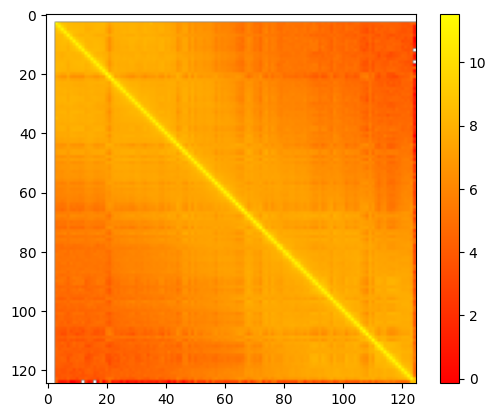

In [119]:
# Example: access adjacency matrices
# hic_data[stage][chrom] returns the adjacency matrix for that stage and chromosome
example = hic_data['early-g1']['chr9']
print(f'Example matrix shape: {example.shape}')

# Select a random chromosome
# as a log scale
plt.imshow(np.log(example), cmap='autumn')
plt.colorbar()
plt.show()

In [120]:
# Combine chr9, chr10, chr11 from each stage, extract upper triangle, flatten
# train0=early-g1, train1=mid-g1, train2=late-g1
# Each train matrix should be (n, 3) where columns are chr9, chr10, chr11

def get_upper_triangle_flat(matrix):
    """Extract upper triangle (including diagonal) and flatten."""
    n = matrix.shape[0]
    upper_tri_indices = np.triu_indices(n)
    return matrix[upper_tri_indices]

def reconstruct_from_upper_triangle(flat_upper, n):
    """Reconstruct square matrix from flattened upper triangle."""
    matrix = np.zeros((n, n))
    triu_indices = np.triu_indices(n)
    matrix[triu_indices] = flat_upper[:len(triu_indices[0])]
    # Make symmetric
    matrix = matrix + matrix.T - np.diag(np.diag(matrix))
    return matrix

# Get chromosomes
chroms = ['chr9', 'chr10', 'chr11']

# For each stage, extract upper triangle from each chromosome and stack as columns
def create_train_matrix(stage):
    """Create (n, 3) matrix from chr9, chr10, chr11 for a given stage."""
    # Get matrices and pad to same size
    matrices = [hic_data[stage][chrom] for chrom in chroms]
    max_size = max(m.shape[0] for m in matrices)
    
    # Pad matrices to max_size
    padded = []
    for m in matrices:
        padded_m = np.zeros((max_size, max_size), dtype=m.dtype)
        padded_m[:m.shape[0], :m.shape[1]] = m
        padded.append(padded_m)
    
    # Extract upper triangle from each and flatten
    flattened = [get_upper_triangle_flat(m) for m in padded]
    
    # Find max length and pad all to same length
    max_len = max(len(f) for f in flattened)
    flattened_padded = [np.pad(f, (0, max_len - len(f)), mode='constant') for f in flattened]
    
    # Stack as columns: (n, 3)
    return np.column_stack(flattened_padded)

train0 = create_train_matrix('early-g1')
train1 = create_train_matrix('mid-g1')
train2 = create_train_matrix('late-g1')

print(f'train0 shape: {train0.shape}')
print(f'train1 shape: {train1.shape}')
print(f'train2 shape: {train2.shape}')

train0 shape: (8515, 3)
train1 shape: (8515, 3)
train2 shape: (8515, 3)


In [121]:
# compute the svd of train0, train1, train2
U0, S0, V0 = np.linalg.svd(train0)
U1, S1, V1 = np.linalg.svd(train1)
U2, S2, V2 = np.linalg.svd(train2)

print(V0.shape)


(3, 3)


In [122]:
# now turn the chromosome 12 into a test vector
test = hic_data['early-g1']['chr12'] + hic_data['mid-g1']['chr12'] + hic_data['late-g1']['chr12']

# Pad test matrix to 130x130 BEFORE extracting upper triangle (matching training data preprocessing)
max_size = 130  # Same as training data (from chr10, which is largest)
test_padded = np.zeros((max_size, max_size), dtype=test.dtype)
test_padded[:test.shape[0], :test.shape[1]] = test

# get the upper triangle of test (now already the correct size, no padding needed)
test_upper = get_upper_triangle_flat(test_padded)

print(f'test shape: {test.shape}')
print(f'test_padded shape: {test_padded.shape}')
print(f'test_upper shape: {test_upper.shape}')
print(f'U0 shape: {U0.shape}')

# project the test vector onto the left singular vectors of train0, train1, train2
proj0 = U0 @ U0.T @ test_upper
proj1 = U1 @ U1.T @ test_upper
proj2 = U2 @ U2.T @ test_upper

# # plot the projections
# plt.plot(proj0, label='early-g1')
# plt.plot(proj1, label='mid-g1')

test shape: (122, 122)
test_padded shape: (130, 130)
test_upper shape: (8515,)
U0 shape: (8515, 8515)


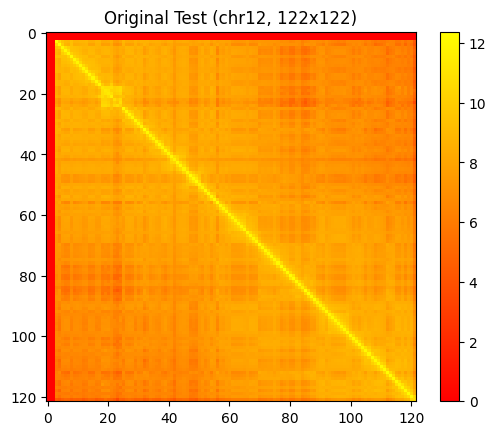

In [123]:
# visualize the test matrix (padded to match training data)
# Note: test_padded is created in Cell 6, but we'll show the original here
plt.imshow(np.log(test + 1), cmap='autumn')
plt.title('Original Test (chr12, 122x122)')
plt.colorbar()
plt.show()

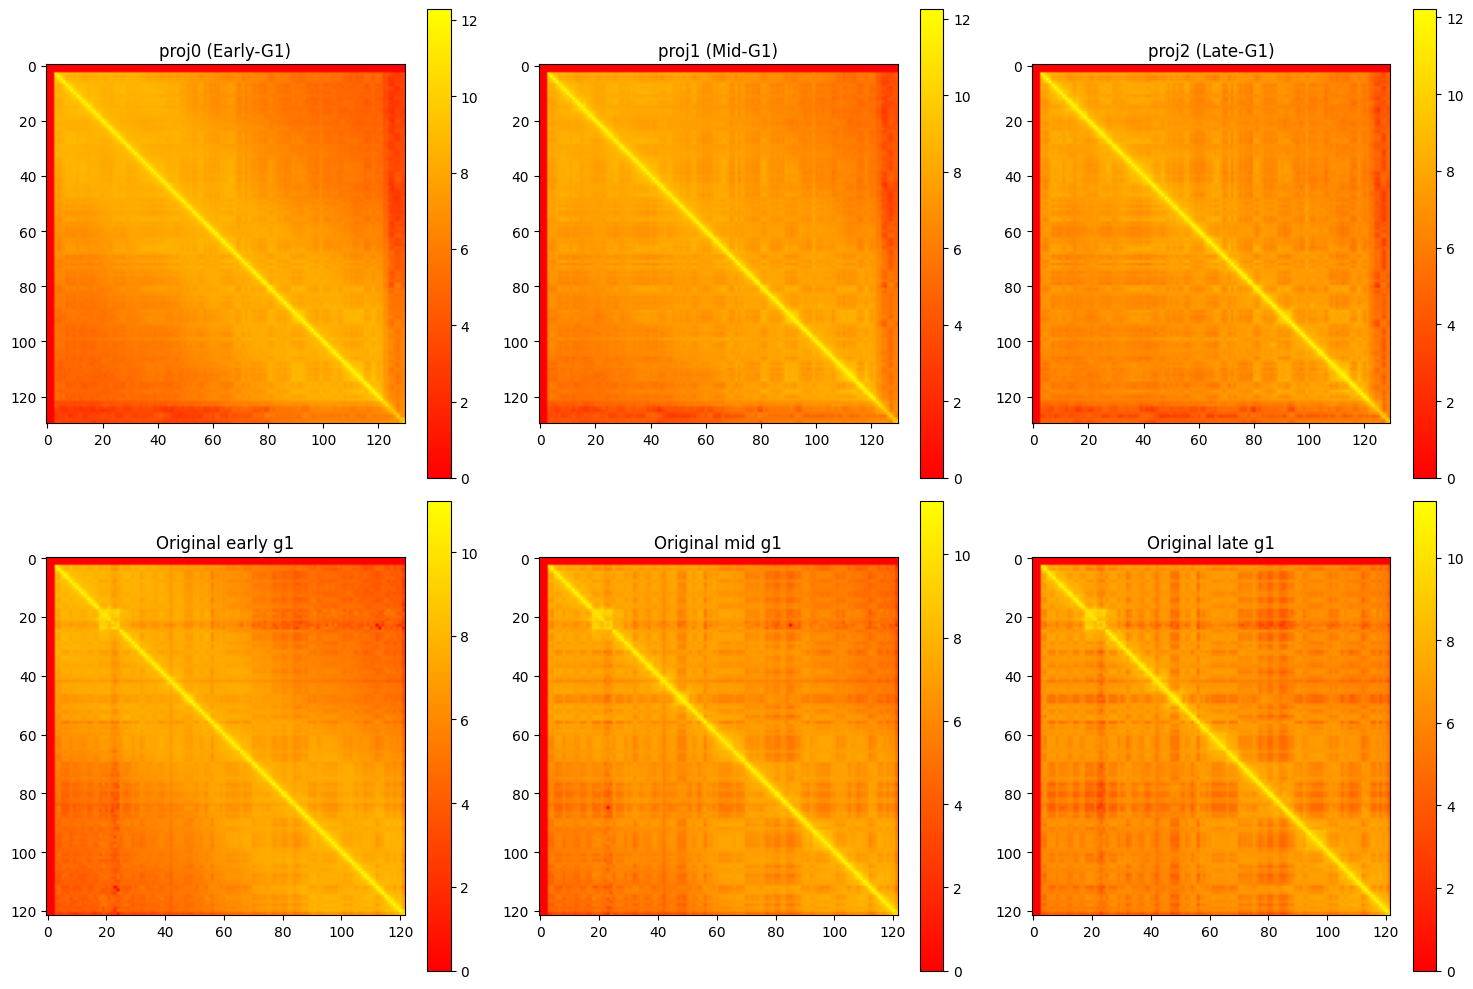

In [135]:
rank = 3
U0 = U0[:, :rank]
U1 = U1[:, :rank]
U2 = U2[:, :rank]

# project the test vector onto the left singular vectors of train0, train1, train2
proj0 = U0 @ U0.T @ test_upper
proj1 = U1 @ U1.T @ test_upper
proj2 = U2 @ U2.T @ test_upper

# Reconstruct projections properly as upper triangles (130x130 matrices)
im0 = reconstruct_from_upper_triangle(proj0, max_size)
im1 = reconstruct_from_upper_triangle(proj1, max_size)
im2 = reconstruct_from_upper_triangle(proj2, max_size)

plt.figure(figsize=(15, 10))
# Top row: projections
plt.subplot(2, 3, 1)
plt.imshow(np.log(im0 + 1), cmap='autumn')
plt.title('proj0 (Early-G1)')
plt.colorbar()

plt.subplot(2, 3, 2)
plt.imshow(np.log(im1 + 1), cmap='autumn')
plt.title('proj1 (Mid-G1)')
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(np.log(im2 + 1), cmap='autumn')
plt.title('proj2 (Late-G1)')
plt.colorbar()

# Bottom row: original test data
plt.subplot(2, 3, 4)
plt.imshow(np.log(hic_data['early-g1']['chr12'] + 1), cmap='autumn')
plt.title('Original early g1')
plt.colorbar()

plt.subplot(2, 3, 5)
plt.imshow(np.log(hic_data['mid-g1']['chr12'] + 1), cmap='autumn')
plt.title('Original mid g1')
plt.colorbar()

plt.subplot(2, 3, 6)
plt.imshow(np.log(hic_data['late-g1']['chr12'] + 1), cmap='autumn')
plt.title('Original late g1')
plt.colorbar()

plt.tight_layout()
plt.show()


In [125]:
# how similar are the basis vectors

# print the frobenius norm of the inner product of the basis vectors
print(np.linalg.norm(U0.T @ U1)/np.sqrt(rank))
print(np.linalg.norm(U0.T @ U2)/np.sqrt(rank))
print(np.linalg.norm(U1.T @ U2)/np.sqrt(rank))

# how similar are the basis vectors


0.9872910065033569
0.9785406681249
0.9942103108697917


In [129]:
# how similar is proj0 to hic_data['early-g1']['chr12'], hic_data['mid-g1']['chr12'], hic_data['late-g1']['chr12']
# Reconstruct proj0 from flattened upper triangle to matrix (130x130), then extract 122x122 portion
proj0_matrix = reconstruct_from_upper_triangle(proj0, max_size)
proj1_matrix = reconstruct_from_upper_triangle(proj1, max_size)
proj2_matrix = reconstruct_from_upper_triangle(proj2, max_size)
proj0_chr12 = proj0_matrix[:122, :122]  # Extract 122x122 to match chr12 size
proj1_chr12 = proj1_matrix[:122, :122]
proj2_chr12 = proj2_matrix[:122, :122]

print(np.linalg.norm(proj0_chr12 - hic_data['early-g1']['chr12'])/np.linalg.norm(hic_data['early-g1']['chr12']))
print(np.linalg.norm(proj0_chr12 - hic_data['mid-g1']['chr12'])/np.linalg.norm(hic_data['mid-g1']['chr12']))
print(np.linalg.norm(proj0_chr12 - hic_data['late-g1']['chr12'])/np.linalg.norm(hic_data['late-g1']['chr12']))
print()
print(np.linalg.norm(proj1_chr12 - hic_data['early-g1']['chr12'])/np.linalg.norm(hic_data['early-g1']['chr12']))
print(np.linalg.norm(proj1_chr12 - hic_data['mid-g1']['chr12'])/np.linalg.norm(hic_data['mid-g1']['chr12']))
print(np.linalg.norm(proj1_chr12 - hic_data['late-g1']['chr12'])/np.linalg.norm(hic_data['late-g1']['chr12']))
print()
print(np.linalg.norm(proj2_chr12 - hic_data['early-g1']['chr12'])/np.linalg.norm(hic_data['early-g1']['chr12']))
print(np.linalg.norm(proj2_chr12 - hic_data['mid-g1']['chr12'])/np.linalg.norm(hic_data['mid-g1']['chr12']))
print(np.linalg.norm(proj2_chr12 - hic_data['late-g1']['chr12'])/np.linalg.norm(hic_data['late-g1']['chr12']))



1.9789707101716414
2.08380668848724
1.7372412084244475

1.9763208382325972
2.0734866605411693
1.7247471281189701

1.9706300766922387
2.0639052617777476
1.712145336342176


TWO issues: 
1. lots of overlap in the basis vectors... they are clearly not orthogonal or even close
2. we want to also learn an alpha beta gamma such that test_data = alpha * test_g1 + beta * test_g2 + gamma * test_g3

In [138]:
# Solve using least squares method:
# b_test = summed_chromosome_test_data
# [ U0  U1  U2 ] [α_test
#                 β_test
#                 γ_test ]  ≈ b_test

# b_test is the test data (flattened upper triangle)
b_test = test_upper  # shape: (8515,)

# Concatenate U0, U1, U2 horizontally: [U0 U1 U2] shape: (8515, 9)
# where U0, U1, U2 each have shape (8515, rank) with rank=3
U_combined = np.hstack([U0, U1, U2])  # shape: (8515, 9)

# Solve least squares: U_combined @ coeffs ≈ b_test
# coeffs = [α_test; β_test; γ_test] where each is (rank,)
coeffs, residuals, rank_svd, s = np.linalg.lstsq(U_combined, b_test, rcond=None)
# coeffs shape: (9,)

# Extract α_test, β_test, γ_test (each is (rank,))
alpha_test = coeffs[:rank]  # shape: (3,)
beta_test = coeffs[rank:2*rank]  # shape: (3,)
gamma_test = coeffs[2*rank:]  # shape: (3,)

print(f"alpha_test shape: {alpha_test.shape}")
print(f"beta_test shape: {beta_test.shape}")
print(f"gamma_test shape: {gamma_test.shape}")
print(f"Residuals (sum of squared errors): {residuals}")

# Phase 0 component = U0 * α_test
phase_0_component = U0 @ alpha_test  # shape: (8515,)

# Phase 1 component = U1 * β_test
phase_1_component = U1 @ beta_test  # shape: (8515,)

# Phase 2 component = U2 * γ_test
phase_2_component = U2 @ gamma_test  # shape: (8515,)

print("alpha_test", alpha_test)
print("beta_test", beta_test)
print("gamma_test", gamma_test)

# Summed reconstruction = sum of these 3
summed_reconstruction = phase_0_component + phase_1_component + phase_2_component  # shape: (8515,)

# Compute reconstruction error
reconstruction_error = np.linalg.norm(b_test - summed_reconstruction) / np.linalg.norm(b_test)
print(f"Reconstruction error (relative): {reconstruction_error:.6e}")

alpha_test shape: (3,)
beta_test shape: (3,)
gamma_test shape: (3,)
Residuals (sum of squared errors): [2.115942e+11]
alpha_test [-2.7049162e+06 -5.4664731e+05 -1.5882423e+05]
beta_test [3.1998502e+06 6.1803850e+05 1.2126805e+05]
gamma_test [-2.2882298e+06 -1.9329266e+05 -3.2241855e+04]
Reconstruction error (relative): 2.474197e-01


/var/folders/l1/qr93hr1j3_51zh7zhxv49qx40000gq/T/ipykernel_16215/1802012431.py:24: RuntimeWarning: invalid value encountered in log
  axes[0, 0].imshow(np.log(phase_0_chr12 + 1), cmap='autumn', aspect='auto')
/var/folders/l1/qr93hr1j3_51zh7zhxv49qx40000gq/T/ipykernel_16215/1802012431.py:43: RuntimeWarning: invalid value encountered in log
  axes[1, 0].imshow(np.log(phase_1_chr12 + 1), cmap='autumn', aspect='auto')


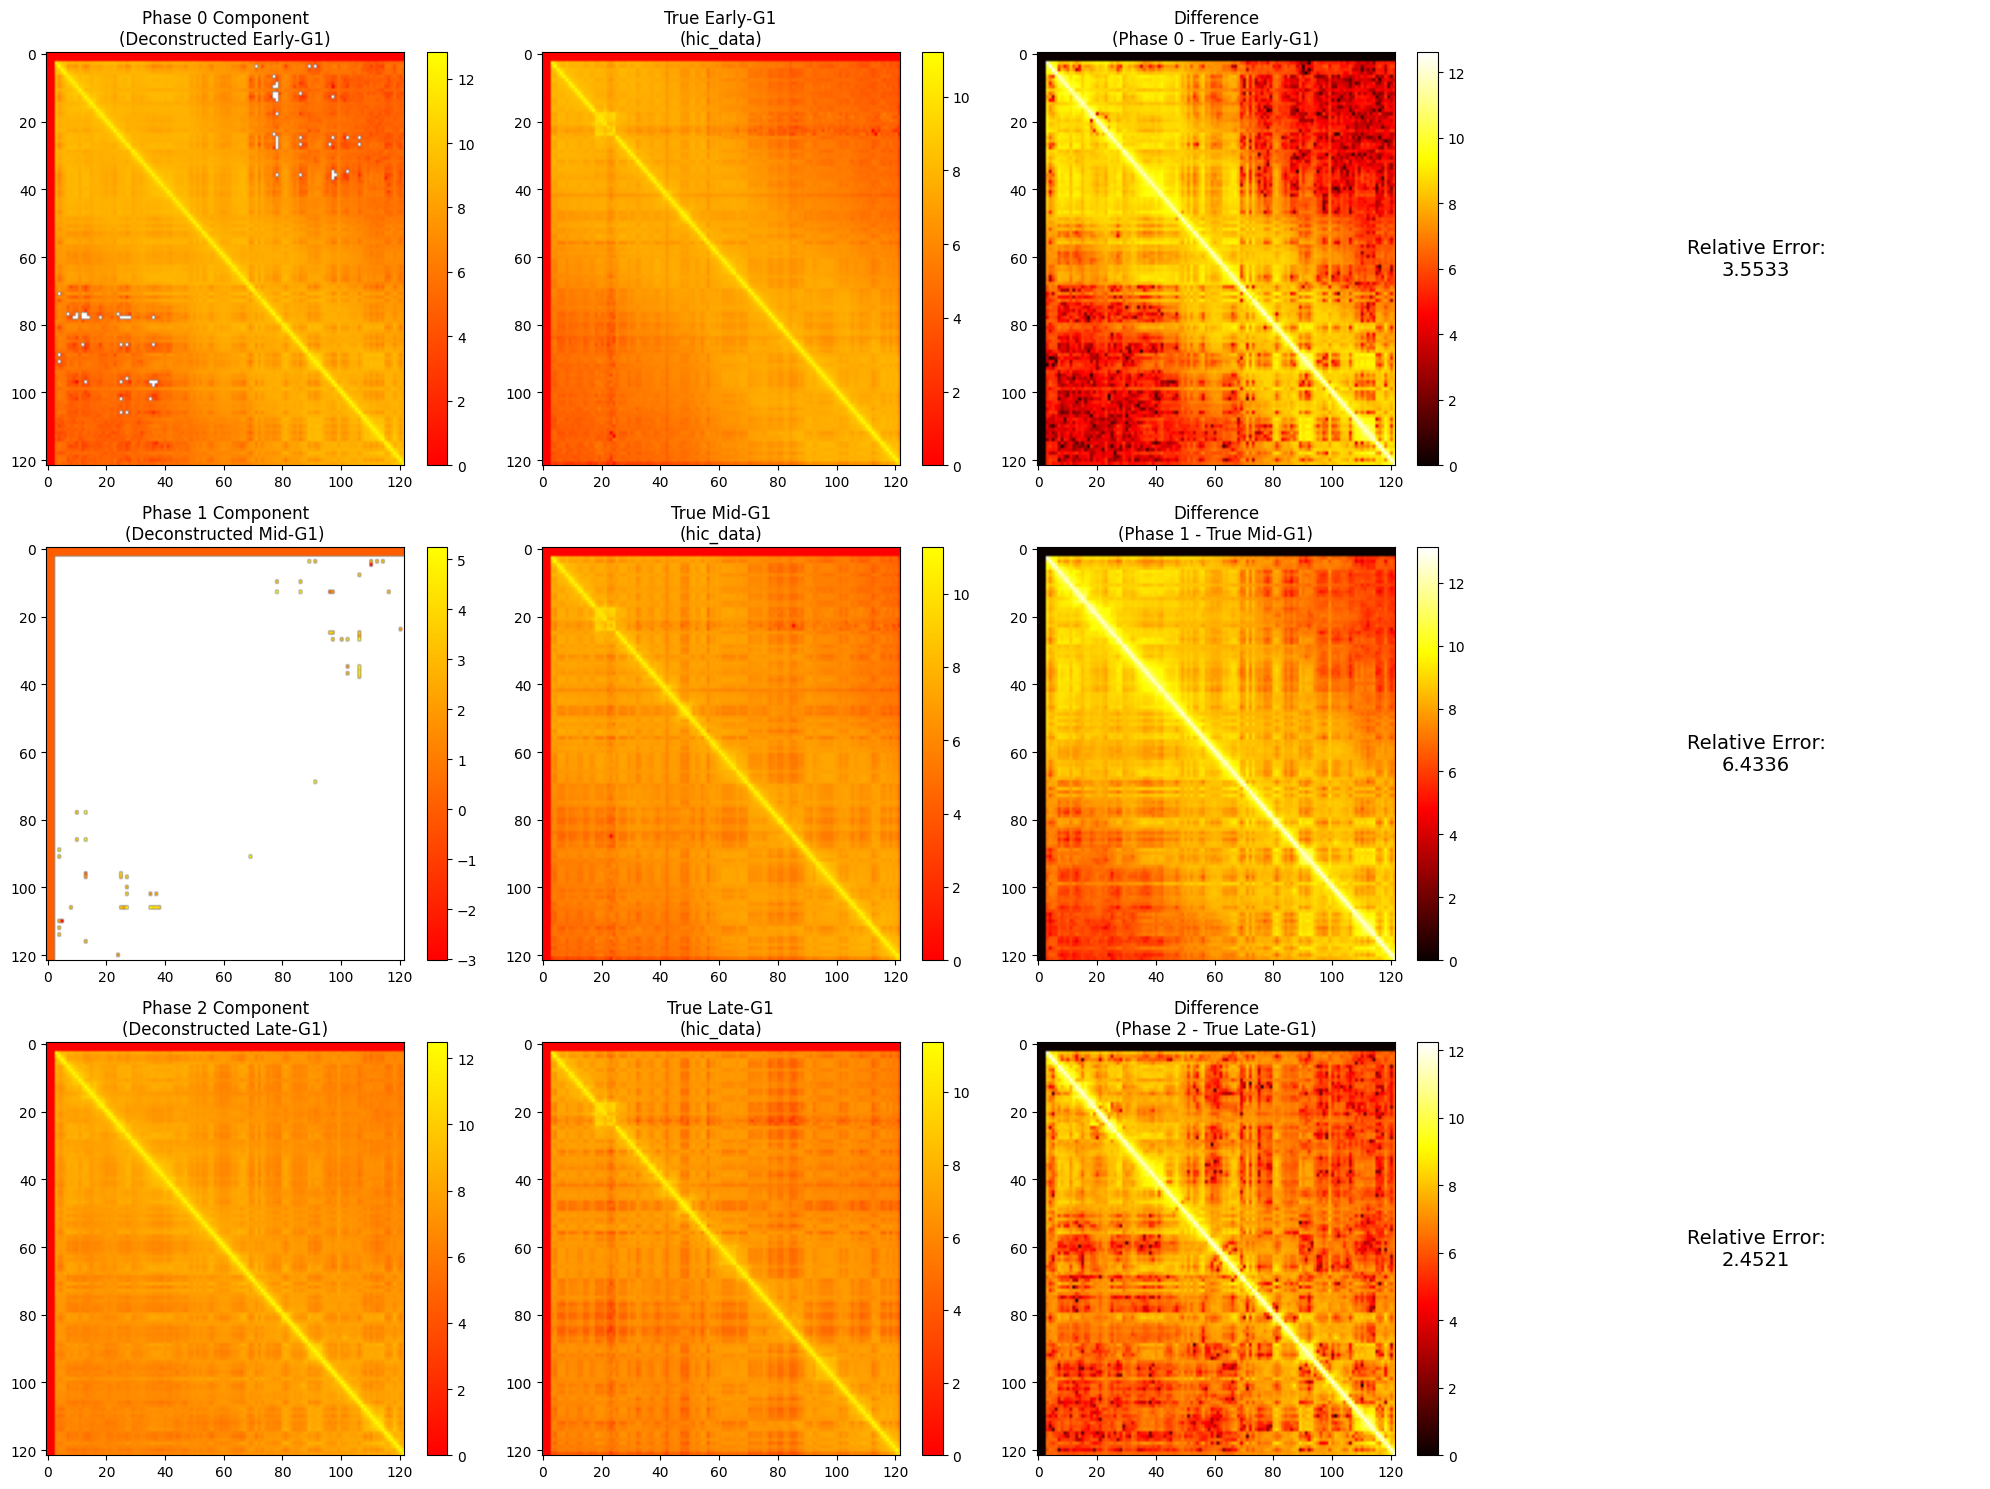

/var/folders/l1/qr93hr1j3_51zh7zhxv49qx40000gq/T/ipykernel_16215/1802012431.py:86: RuntimeWarning: invalid value encountered in log
  axes[0].imshow(np.log(summed_reconstruction_chr12 + 1), cmap='autumn', aspect='auto')


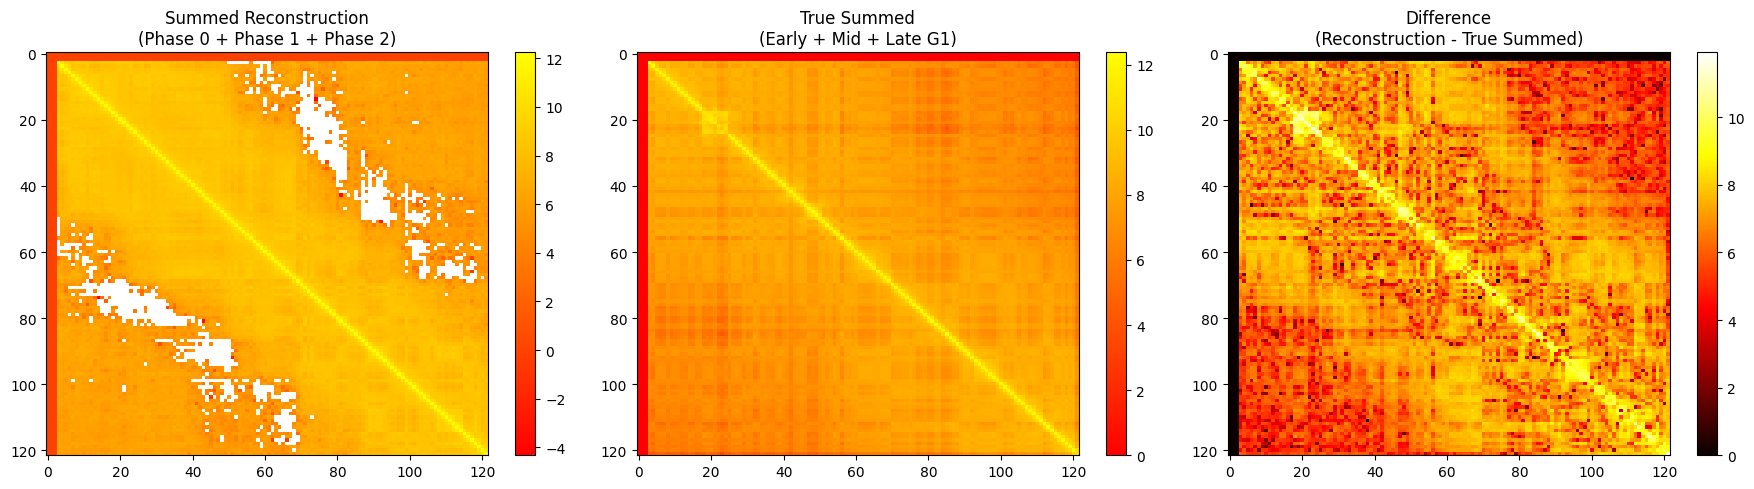

Summary of Reconstruction Errors:
Phase 0 (Early-G1) relative error: 3.553342
Phase 1 (Mid-G1) relative error: 6.433592
Phase 2 (Late-G1) relative error: 2.452148
Summed reconstruction relative error: 0.264336


In [137]:
# Reconstruct phase components from flattened vectors to matrices
# Phase components are currently (8515,) flattened upper triangles
phase_0_matrix = reconstruct_from_upper_triangle(phase_0_component, max_size)  # (130, 130)
phase_1_matrix = reconstruct_from_upper_triangle(phase_1_component, max_size)  # (130, 130)
phase_2_matrix = reconstruct_from_upper_triangle(phase_2_component, max_size)  # (130, 130)
summed_reconstruction_matrix = reconstruct_from_upper_triangle(summed_reconstruction, max_size)  # (130, 130)

# Extract 122x122 portion to match chr12 size
phase_0_chr12 = phase_0_matrix[:122, :122]
phase_1_chr12 = phase_1_matrix[:122, :122]
phase_2_chr12 = phase_2_matrix[:122, :122]
summed_reconstruction_chr12 = summed_reconstruction_matrix[:122, :122]

# Get true stage contacts
true_early_g1 = hic_data['early-g1']['chr12']  # (122, 122)
true_mid_g1 = hic_data['mid-g1']['chr12']  # (122, 122)
true_late_g1 = hic_data['late-g1']['chr12']  # (122, 122)
true_summed = true_early_g1 + true_mid_g1 + true_late_g1  # (122, 122)

# Create comparison plots: deconstructed phases vs true stage contacts
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Row 1: Phase 0 (Early-G1) vs True Early-G1
axes[0, 0].imshow(np.log(phase_0_chr12 + 1), cmap='autumn', aspect='auto')
axes[0, 0].set_title('Phase 0 Component\n(Deconstructed Early-G1)')
plt.colorbar(axes[0, 0].images[0], ax=axes[0, 0])

axes[0, 1].imshow(np.log(true_early_g1 + 1), cmap='autumn', aspect='auto')
axes[0, 1].set_title('True Early-G1\n(hic_data)')
plt.colorbar(axes[0, 1].images[0], ax=axes[0, 1])

axes[0, 2].imshow(np.log(np.abs(phase_0_chr12 - true_early_g1) + 1), cmap='hot', aspect='auto')
axes[0, 2].set_title('Difference\n(Phase 0 - True Early-G1)')
plt.colorbar(axes[0, 2].images[0], ax=axes[0, 2])

# Compute relative error for phase 0
error_phase0 = np.linalg.norm(phase_0_chr12 - true_early_g1) / np.linalg.norm(true_early_g1)
axes[0, 3].text(0.5, 0.5, f'Relative Error:\n{error_phase0:.4f}', 
                ha='center', va='center', fontsize=14, transform=axes[0, 3].transAxes)
axes[0, 3].axis('off')

# Row 2: Phase 1 (Mid-G1) vs True Mid-G1
axes[1, 0].imshow(np.log(phase_1_chr12 + 1), cmap='autumn', aspect='auto')
axes[1, 0].set_title('Phase 1 Component\n(Deconstructed Mid-G1)')
plt.colorbar(axes[1, 0].images[0], ax=axes[1, 0])

axes[1, 1].imshow(np.log(true_mid_g1 + 1), cmap='autumn', aspect='auto')
axes[1, 1].set_title('True Mid-G1\n(hic_data)')
plt.colorbar(axes[1, 1].images[0], ax=axes[1, 1])

axes[1, 2].imshow(np.log(np.abs(phase_1_chr12 - true_mid_g1) + 1), cmap='hot', aspect='auto')
axes[1, 2].set_title('Difference\n(Phase 1 - True Mid-G1)')
plt.colorbar(axes[1, 2].images[0], ax=axes[1, 2])

# Compute relative error for phase 1
error_phase1 = np.linalg.norm(phase_1_chr12 - true_mid_g1) / np.linalg.norm(true_mid_g1)
axes[1, 3].text(0.5, 0.5, f'Relative Error:\n{error_phase1:.4f}', 
                ha='center', va='center', fontsize=14, transform=axes[1, 3].transAxes)
axes[1, 3].axis('off')

# Row 3: Phase 2 (Late-G1) vs True Late-G1
axes[2, 0].imshow(np.log(phase_2_chr12 + 1), cmap='autumn', aspect='auto')
axes[2, 0].set_title('Phase 2 Component\n(Deconstructed Late-G1)')
plt.colorbar(axes[2, 0].images[0], ax=axes[2, 0])

axes[2, 1].imshow(np.log(true_late_g1 + 1), cmap='autumn', aspect='auto')
axes[2, 1].set_title('True Late-G1\n(hic_data)')
plt.colorbar(axes[2, 1].images[0], ax=axes[2, 1])

axes[2, 2].imshow(np.log(np.abs(phase_2_chr12 - true_late_g1) + 1), cmap='hot', aspect='auto')
axes[2, 2].set_title('Difference\n(Phase 2 - True Late-G1)')
plt.colorbar(axes[2, 2].images[0], ax=axes[2, 2])

# Compute relative error for phase 2
error_phase2 = np.linalg.norm(phase_2_chr12 - true_late_g1) / np.linalg.norm(true_late_g1)
axes[2, 3].text(0.5, 0.5, f'Relative Error:\n{error_phase2:.4f}', 
                ha='center', va='center', fontsize=14, transform=axes[2, 3].transAxes)
axes[2, 3].axis('off')

plt.tight_layout()
plt.show()

# Also plot summed reconstruction vs true summed
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].imshow(np.log(summed_reconstruction_chr12 + 1), cmap='autumn', aspect='auto')
axes[0].set_title('Summed Reconstruction\n(Phase 0 + Phase 1 + Phase 2)')
plt.colorbar(axes[0].images[0], ax=axes[0])

axes[1].imshow(np.log(true_summed + 1), cmap='autumn', aspect='auto')
axes[1].set_title('True Summed\n(Early + Mid + Late G1)')
plt.colorbar(axes[1].images[0], ax=axes[1])

axes[2].imshow(np.log(np.abs(summed_reconstruction_chr12 - true_summed) + 1), cmap='hot', aspect='auto')
axes[2].set_title('Difference\n(Reconstruction - True Summed)')
plt.colorbar(axes[2].images[0], ax=axes[2])

plt.tight_layout()
plt.show()

# Print summary errors
print("Summary of Reconstruction Errors:")
print(f"Phase 0 (Early-G1) relative error: {error_phase0:.6f}")
print(f"Phase 1 (Mid-G1) relative error: {error_phase1:.6f}")
print(f"Phase 2 (Late-G1) relative error: {error_phase2:.6f}")
summed_error = np.linalg.norm(summed_reconstruction_chr12 - true_summed) / np.linalg.norm(true_summed)
print(f"Summed reconstruction relative error: {summed_error:.6f}")


In [139]:
# b_test is the test data (flattened upper triangle)
b_test = test_upper  # shape: (8515,)

# Concatenate U0, U1, U2 horizontally: [U0 U1 U2] shape: (8515, 9)
# where U0, U1, U2 each have shape (8515, rank) with rank=3
rank = U0.shape[1]  # should be 3
U_combined = np.hstack([U0, U1, U2])  # shape: (8515, 9)

# ---------- Add diagonal penalty (ridge-style) ----------
lam = 0.1  # regularization strength; you can tune this

A = U_combined  # (8515, 9)
D = A.shape[1]  # 9

# Since all blocks (alpha, beta, gamma) have same size rank=3,
# a simple identity penalty already treats them equally.
# If in the future ranks differ, you can weight each block by 1/rank.
W = np.eye(D)  # diagonal penalty matrix

# Solve (Aᵀ A + λ W) θ = Aᵀ b_test
lhs = A.T @ A + lam * W        # (9, 9)
rhs = A.T @ b_test             # (9,)

coeffs = np.linalg.solve(lhs, rhs)  # (9,)
# -------------------------------------------------------

# Extract α_test, β_test, γ_test (each is (rank,))
alpha_test = coeffs[:rank]              # shape: (3,)
beta_test  = coeffs[rank:2*rank]        # shape: (3,)
gamma_test = coeffs[2*rank:3*rank]      # shape: (3,)

print(f"alpha_test shape: {alpha_test.shape}")
print(f"beta_test shape:  {beta_test.shape}")
print(f"gamma_test shape: {gamma_test.shape}")

# Phase 0 component = U0 * α_test
phase_0_component = U0 @ alpha_test  # shape: (8515,)

# Phase 1 component = U1 * β_test
phase_1_component = U1 @ beta_test   # shape: (8515,)

# Phase 2 component = U2 * γ_test
phase_2_component = U2 @ gamma_test  # shape: (8515,)

# Summed reconstruction = sum of these 3
summed_reconstruction = (
    phase_0_component +
    phase_1_component +
    phase_2_component
)  # shape: (8515,)

# Compute reconstruction error
reconstruction_error = np.linalg.norm(b_test - summed_reconstruction) / np.linalg.norm(b_test)
print(f"Reconstruction error (relative): {reconstruction_error:.6e}")


alpha_test shape: (3,)
beta_test shape:  (3,)
gamma_test shape: (3,)
Reconstruction error (relative): 2.587128e-01


## image code

/var/folders/l1/qr93hr1j3_51zh7zhxv49qx40000gq/T/ipykernel_16215/1802012431.py:24: RuntimeWarning: invalid value encountered in log
  axes[0, 0].imshow(np.log(phase_0_chr12 + 1), cmap='autumn', aspect='auto')


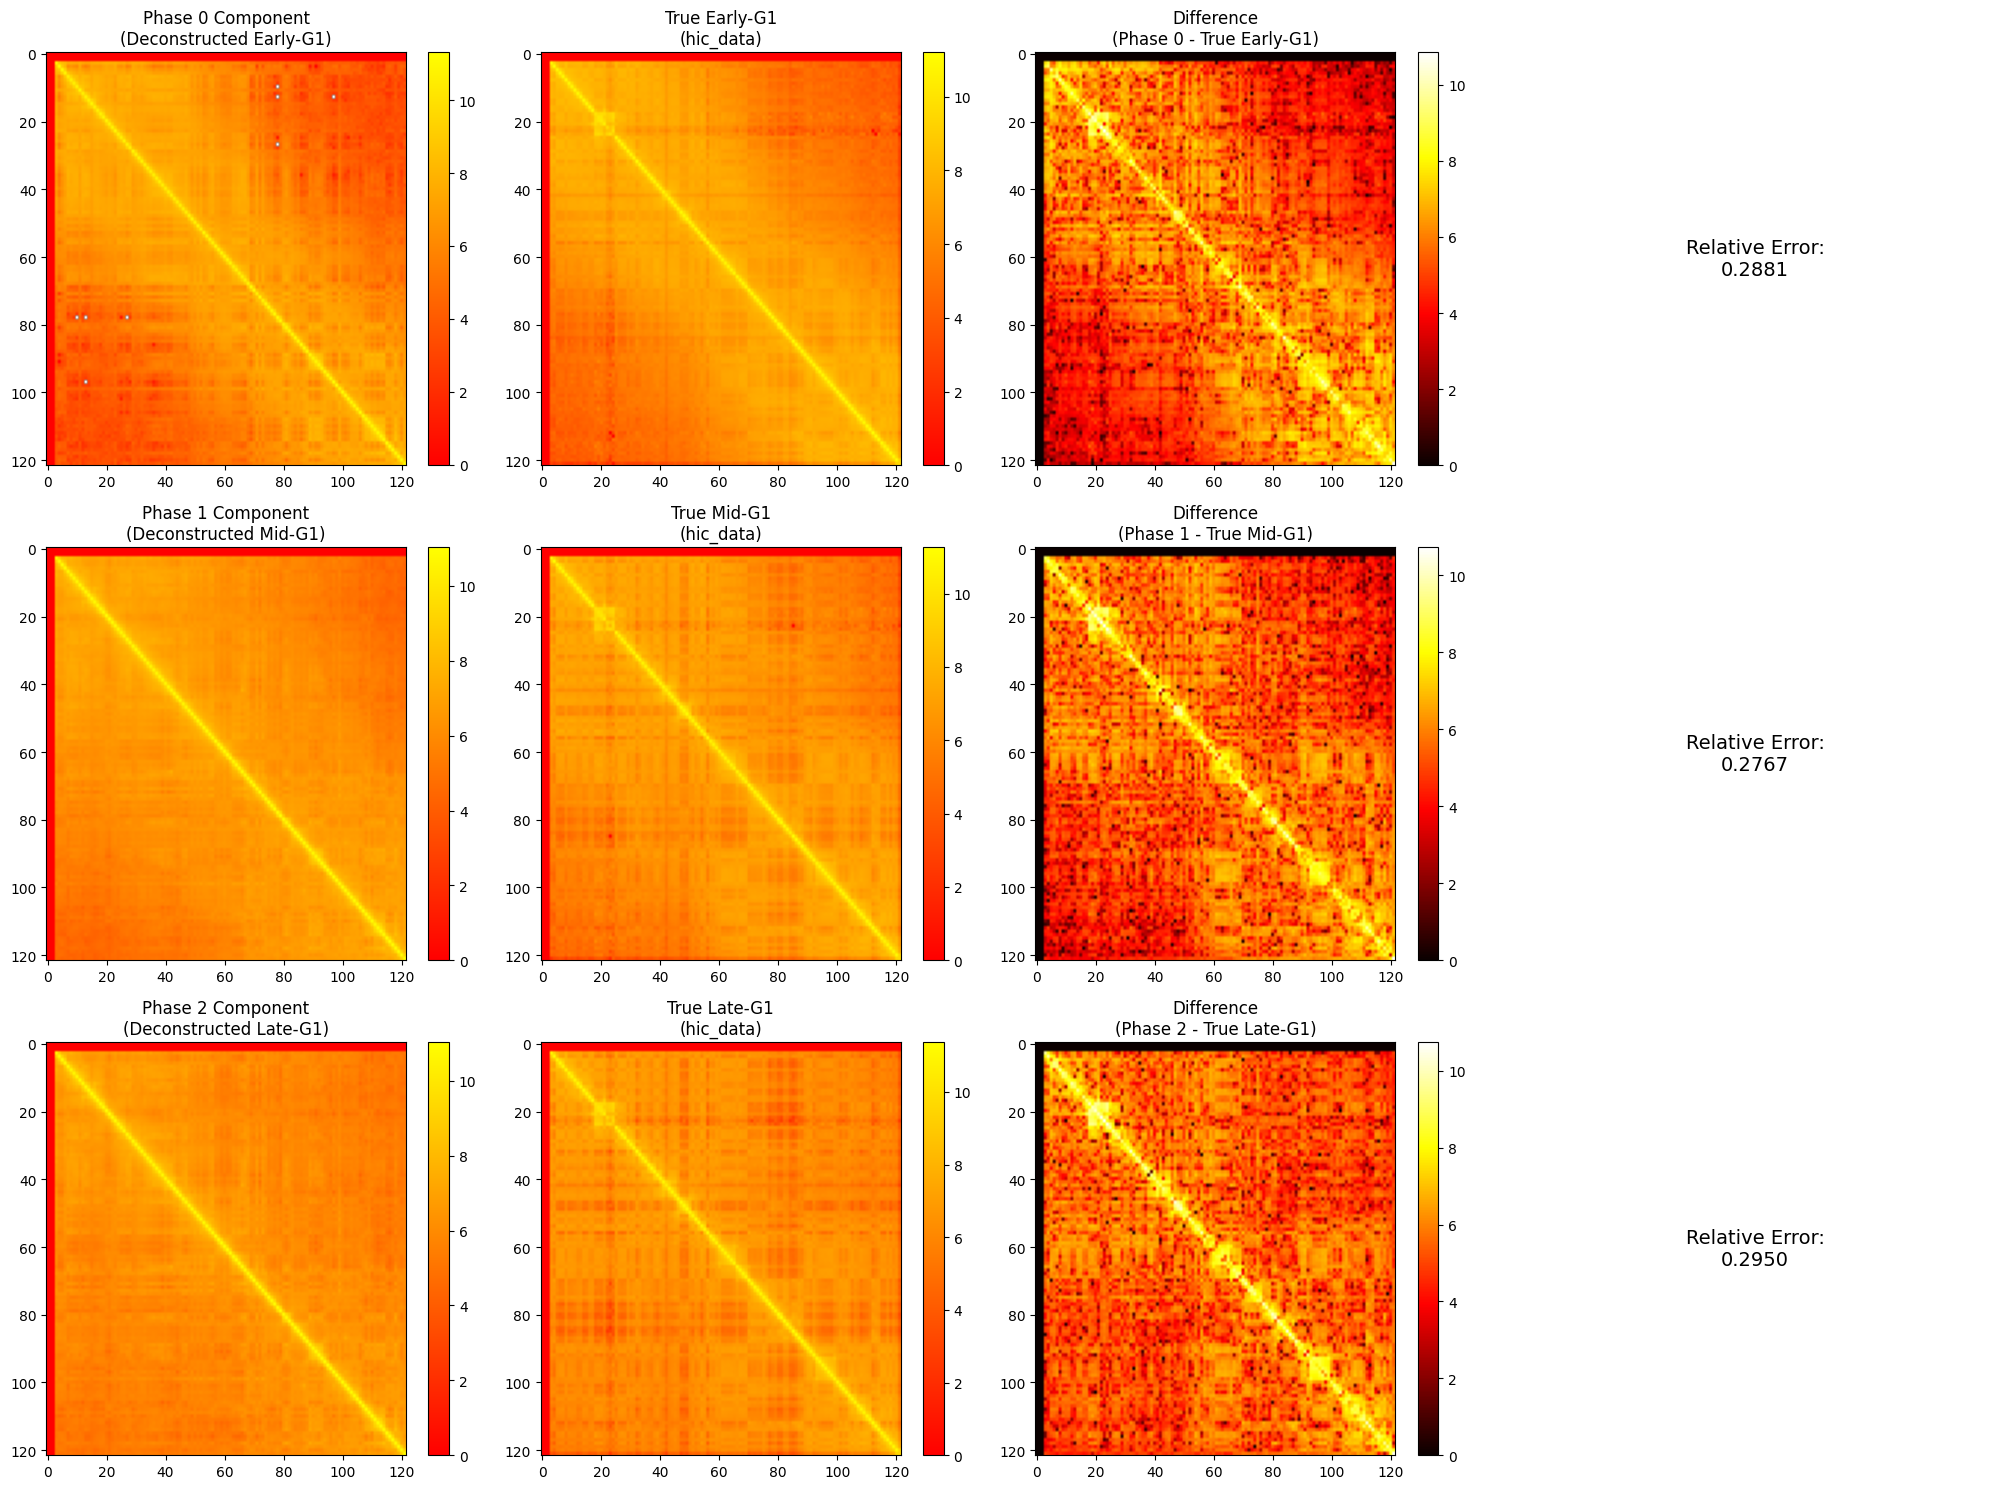

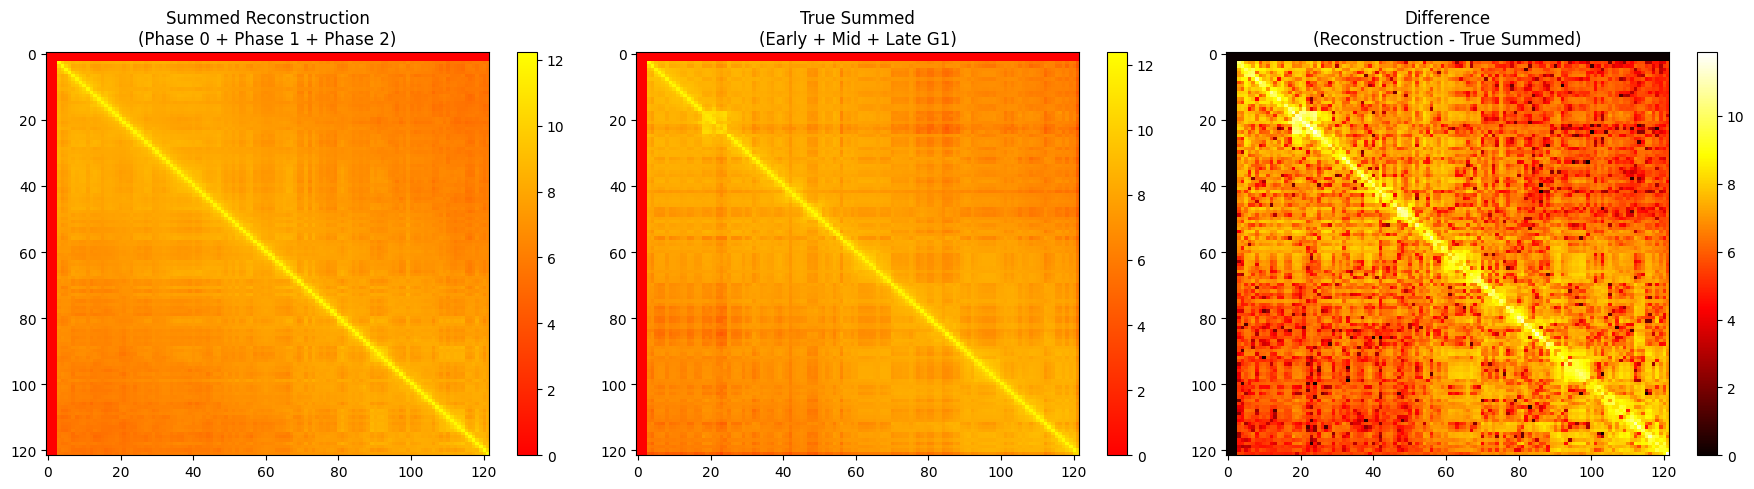

Summary of Reconstruction Errors:
Phase 0 (Early-G1) relative error: 0.288106
Phase 1 (Mid-G1) relative error: 0.276743
Phase 2 (Late-G1) relative error: 0.294971
Summed reconstruction relative error: 0.269389


In [140]:
# Reconstruct phase components from flattened vectors to matrices
# Phase components are currently (8515,) flattened upper triangles
phase_0_matrix = reconstruct_from_upper_triangle(phase_0_component, max_size)  # (130, 130)
phase_1_matrix = reconstruct_from_upper_triangle(phase_1_component, max_size)  # (130, 130)
phase_2_matrix = reconstruct_from_upper_triangle(phase_2_component, max_size)  # (130, 130)
summed_reconstruction_matrix = reconstruct_from_upper_triangle(summed_reconstruction, max_size)  # (130, 130)

# Extract 122x122 portion to match chr12 size
phase_0_chr12 = phase_0_matrix[:122, :122]
phase_1_chr12 = phase_1_matrix[:122, :122]
phase_2_chr12 = phase_2_matrix[:122, :122]
summed_reconstruction_chr12 = summed_reconstruction_matrix[:122, :122]

# Get true stage contacts
true_early_g1 = hic_data['early-g1']['chr12']  # (122, 122)
true_mid_g1 = hic_data['mid-g1']['chr12']  # (122, 122)
true_late_g1 = hic_data['late-g1']['chr12']  # (122, 122)
true_summed = true_early_g1 + true_mid_g1 + true_late_g1  # (122, 122)

# Create comparison plots: deconstructed phases vs true stage contacts
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Row 1: Phase 0 (Early-G1) vs True Early-G1
axes[0, 0].imshow(np.log(phase_0_chr12 + 1), cmap='autumn', aspect='auto')
axes[0, 0].set_title('Phase 0 Component\n(Deconstructed Early-G1)')
plt.colorbar(axes[0, 0].images[0], ax=axes[0, 0])

axes[0, 1].imshow(np.log(true_early_g1 + 1), cmap='autumn', aspect='auto')
axes[0, 1].set_title('True Early-G1\n(hic_data)')
plt.colorbar(axes[0, 1].images[0], ax=axes[0, 1])

axes[0, 2].imshow(np.log(np.abs(phase_0_chr12 - true_early_g1) + 1), cmap='hot', aspect='auto')
axes[0, 2].set_title('Difference\n(Phase 0 - True Early-G1)')
plt.colorbar(axes[0, 2].images[0], ax=axes[0, 2])

# Compute relative error for phase 0
error_phase0 = np.linalg.norm(phase_0_chr12 - true_early_g1) / np.linalg.norm(true_early_g1)
axes[0, 3].text(0.5, 0.5, f'Relative Error:\n{error_phase0:.4f}', 
                ha='center', va='center', fontsize=14, transform=axes[0, 3].transAxes)
axes[0, 3].axis('off')

# Row 2: Phase 1 (Mid-G1) vs True Mid-G1
axes[1, 0].imshow(np.log(phase_1_chr12 + 1), cmap='autumn', aspect='auto')
axes[1, 0].set_title('Phase 1 Component\n(Deconstructed Mid-G1)')
plt.colorbar(axes[1, 0].images[0], ax=axes[1, 0])

axes[1, 1].imshow(np.log(true_mid_g1 + 1), cmap='autumn', aspect='auto')
axes[1, 1].set_title('True Mid-G1\n(hic_data)')
plt.colorbar(axes[1, 1].images[0], ax=axes[1, 1])

axes[1, 2].imshow(np.log(np.abs(phase_1_chr12 - true_mid_g1) + 1), cmap='hot', aspect='auto')
axes[1, 2].set_title('Difference\n(Phase 1 - True Mid-G1)')
plt.colorbar(axes[1, 2].images[0], ax=axes[1, 2])

# Compute relative error for phase 1
error_phase1 = np.linalg.norm(phase_1_chr12 - true_mid_g1) / np.linalg.norm(true_mid_g1)
axes[1, 3].text(0.5, 0.5, f'Relative Error:\n{error_phase1:.4f}', 
                ha='center', va='center', fontsize=14, transform=axes[1, 3].transAxes)
axes[1, 3].axis('off')

# Row 3: Phase 2 (Late-G1) vs True Late-G1
axes[2, 0].imshow(np.log(phase_2_chr12 + 1), cmap='autumn', aspect='auto')
axes[2, 0].set_title('Phase 2 Component\n(Deconstructed Late-G1)')
plt.colorbar(axes[2, 0].images[0], ax=axes[2, 0])

axes[2, 1].imshow(np.log(true_late_g1 + 1), cmap='autumn', aspect='auto')
axes[2, 1].set_title('True Late-G1\n(hic_data)')
plt.colorbar(axes[2, 1].images[0], ax=axes[2, 1])

axes[2, 2].imshow(np.log(np.abs(phase_2_chr12 - true_late_g1) + 1), cmap='hot', aspect='auto')
axes[2, 2].set_title('Difference\n(Phase 2 - True Late-G1)')
plt.colorbar(axes[2, 2].images[0], ax=axes[2, 2])

# Compute relative error for phase 2
error_phase2 = np.linalg.norm(phase_2_chr12 - true_late_g1) / np.linalg.norm(true_late_g1)
axes[2, 3].text(0.5, 0.5, f'Relative Error:\n{error_phase2:.4f}', 
                ha='center', va='center', fontsize=14, transform=axes[2, 3].transAxes)
axes[2, 3].axis('off')

plt.tight_layout()
plt.show()

# Also plot summed reconstruction vs true summed
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].imshow(np.log(summed_reconstruction_chr12 + 1), cmap='autumn', aspect='auto')
axes[0].set_title('Summed Reconstruction\n(Phase 0 + Phase 1 + Phase 2)')
plt.colorbar(axes[0].images[0], ax=axes[0])

axes[1].imshow(np.log(true_summed + 1), cmap='autumn', aspect='auto')
axes[1].set_title('True Summed\n(Early + Mid + Late G1)')
plt.colorbar(axes[1].images[0], ax=axes[1])

axes[2].imshow(np.log(np.abs(summed_reconstruction_chr12 - true_summed) + 1), cmap='hot', aspect='auto')
axes[2].set_title('Difference\n(Reconstruction - True Summed)')
plt.colorbar(axes[2].images[0], ax=axes[2])

plt.tight_layout()
plt.show()

# Print summary errors
print("Summary of Reconstruction Errors:")
print(f"Phase 0 (Early-G1) relative error: {error_phase0:.6f}")
print(f"Phase 1 (Mid-G1) relative error: {error_phase1:.6f}")
print(f"Phase 2 (Late-G1) relative error: {error_phase2:.6f}")
summed_error = np.linalg.norm(summed_reconstruction_chr12 - true_summed) / np.linalg.norm(true_summed)
print(f"Summed reconstruction relative error: {summed_error:.6f}")
